# design leader for multiple designs

## set-up
import and function

In [2]:
import infrared as ir
import infrared.rna as rna
import RNA
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

/tmp/ipykernel_2367844/185338957.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
def remove_positioned_gaps(sequence, structure):
    remove = [i for i, nt in enumerate(sequence) if nt == '-']
    new_ss = [structure[i] for i in range(len(structure)) if i not in remove]
    return ''.join(new_ss)

In [4]:
# sequences from new designs
design2 = 'UGUCAGGCCUAG-GAAAAGA-CUAGCCACGGAU--------GCGUUC--A-----AUUCGUGCAGCCUGUUU-----GAGUGUUU'
design3 = 'UGUCAGGCCUCG-UCCAGU--CGAGCCACGUGCC-------GGUCCG--A----GGUACGUGCAGCCUGUUUUUC--CGGAUUUU'
design7 = 'UGUCAGGCCCUC-GUUCA---GAGGCCACGUCU-A------GAG-----CAAAA-AGACGUGCAGCCUGUU---------UUUUU'
design10 =  'UGUCAGGCCUCUGUAAC---CAGAGCCACGUGU--------UUUAACAUU-----GCACGUGCAGCCUGUUUUU-AUGUUAAGUC'
designs = [design2, design3,design7, design10]

In [5]:
structures = ['...((((((((((.......))))).((((((((....................))))))))..)))))................',
		      '((............................................................)).....................',
		      '.........................................((((((((..........................))))))))..']

xrRNA_strucs = []
xrRNA_seqs = []
for seq in designs:
	xrRNA_strucs.append([remove_positioned_gaps(seq, s) for s in structures])
	xrRNA_seqs.append(seq.replace('-',''))


In [6]:
extended_iupac_nucleotides = {
    'A': 'A',
    'C': 'C',
    'G': 'G',
    'U': 'U',
    'R': 'AG',
    'N': 'ACGU',
    'X': 'ACGU-',
    '-': '-',
    '.': '-'
}

# convert extended iupac nts to RNA nts
def iupacvalues(symbol):
    return [ rna.nucleotide_to_value(x) for x in extended_iupac_nucleotides[symbol] ]

# convert IR sample to RNA sequence
def sample_to_seq(sample):
    return rna.values_to_seq(sample.values())

# calculate GC content of seq
def calculate_gc(seq):
    seq = seq.upper()
    return (seq.count('G') + seq.count('C')) / len(seq)

# calculate target frequency of given sequence and ss
def target_frequency(sequence, ss):
    fc = RNA.fold_compound(sequence.replace('-',''))
    fc.pf()
    return fc.pr_structure(ss)

# check if secondary structure is unpaired in the beginning
def acceptable_seq(ss):
    if not ss.startswith('........'):
        return False
    return True

In [7]:
# test suboptimal secondary structures and check if they interfere with xrRNA structure or unpaired region of the leader
def test_suboptimal_ss(leader_seq, xrRNA_seq, xrRNA_ss):
    target_ss = remove_positioned_gaps(leader_seq, target)
    target_ss = target_ss + xrRNA_ss

    seq = leader_seq.replace('-','') + xrRNA_seq

    fc = RNA.fold_compound(seq)
    (ss, mfe) = fc.mfe()
    strikes = 0
    for s in fc.subopt(500):
        if s.structure[len(leader_seq):] != xrRNA_ss or not s.structure.startswith('.....'):
            return False
    return True

# print suboptimal secondary structures
def print_suboptimal_ss(leader_seq, xrRNA_seq, xrRNA_ss, sample_size=1000):
    ss_leader = remove_positioned_gaps(leader_seq, target)
    target_ss = ss_leader + xrRNA_ss

    seq = leader_seq.replace('-','') + xrRNA_seq
    
    fc = RNA.fold_compound(seq)
    (ss, mfe) = fc.mfe()
    suboptimal_ss = []
    for s in fc.subopt(sample_size):
        if s.structure not in suboptimal_ss:
            print(seq)
            print(f"{s.structure}\t{s.energy:6.2f}")
            print(target_ss)
            print(f'{"-" * len(ss_leader) + "+" * len(xrRNA_seq)}\n')
            suboptimal_ss.append(s.structure)
    return True

# test wheter there are interactions between the xrRNA and leader structure
def test_interaction(leader_seq, xrRNA_seq, xrRNA_ss,threshold = 0.01):
    leader_seq = leader_seq.replace('-','')

    seq = leader_seq + xrRNA_seq
    fold_compound = RNA.fold_compound(seq)
    fold_compound.pf()
    base_pair_probs = np.array(fold_compound.bpp())
    for i in range(len(leader_seq)):
        for j in range(len(leader_seq), len(seq)):
            if base_pair_probs[i][j] > threshold:  # Adjust threshold as needed
                return False
    return True

## IR model 
define IR model 

In [8]:
## GCUAA stays unpaired, then adding helix to leader
target =         ".........((((((....))))))...."
iupac_sequence = 'GCUAANNNXNNNNNXNNNXXNNNNNNNXX'
n = len(target)
model = ir.Model()
model.add_variables(n, 5)

# add constraints to model
for i, x in enumerate(iupac_sequence):
    model.add_constraints(ir.ValueIn(i, iupacvalues(x)))
model.add_constraints(rna.BPComp(i,j) for (i,j) in rna.parse(target))
model.add_functions([rna.GCCont(i) for i in range(n)], 'gc')


## sampling approach
create samples for leader and test which fit the best according to target frequency

In [ ]:

# create potential leader samples
sample_size = 1000000
sampler = ir.Sampler(model)
# samples = [sample_to_seq(sampler.sample()) for _ in range(10000)]
sampler.set_target( 0.5 * n, 0.1 * n, 'gc' )
samples = [sample_to_seq(sampler.targeted_sample()) for _ in tqdm(range(sample_size))]

In [37]:
# check all samples and save samples that are unpaired in the beginning (GCUAA)
ok_leader= []
for seq in tqdm(samples):
    seq_ = seq.replace('-','')
    fc  = RNA.fold_compound(seq_)
    (ss, mfe) = fc.mfe()
    # check if GCUAA of ss is unpaired
    if acceptable_seq(ss):
        ok_leader.append(seq)

100%|██████████| 1000000/1000000 [02:01<00:00, 8202.32it/s]


In [ ]:
# using one leader for all design

threshold = 0.1
good_candidates = []

for seq in tqdm(ok_leader):
    good = True
    for i in range(len(designs)):
        if not test_interaction(seq, xrRNA_seqs[i], xrRNA_strucs[i][0], threshold):
            good = False
            break
    if good:
        good_candidates.append(seq)
        print(seq)



 44%|████▎     | 177695/407840 [22:13<31:33, 121.53it/s] 

['GCUAAUUUUGGAACCAUGCGGUUCCUUG-']


 96%|█████████▌| 392078/407840 [48:30<01:56, 135.86it/s] 

['GCUAAUUUUGGAACCAUGCGGUUCCUUG-', 'GCUAAGUGUAGCCGGUCACCCGGCUUU-G']


100%|██████████| 407840/407840 [50:23<00:00, 134.91it/s]


In [68]:
for seq in good_candidates:
    print(f'leader: {seq}')
    ss = remove_positioned_gaps(seq, target)
    for j in range(len(designs)):
        target_ss = ss+xrRNA_strucs[j][0]
        whole_seq = seq + xrRNA_seqs[j]
        print(f'{target_frequency(whole_seq, target_ss):.2f}')
    print('-'*50)

leader: GCUAAUUUUGGAACCAUGCGGUUCCUUG-
0.29
0.47
0.58
0.40
--------------------------------------------------
leader: GCUAAGUGUAGCCGGUCACCCGGCUUU-G
0.17
0.25
0.32
0.23
--------------------------------------------------


In [40]:
# go over all ok leader and save leader with best target frequency
# prints current 
best_seq = None
best_freq = 0
freq_threshold = 0.1
leader_n = len(ok_leader)
for i, seq in enumerate(ok_leader):
    cur_sum_freq = 0
    for j in range(len(designs)):
        target_ss = remove_positioned_gaps(seq, target)
        target_ss += xrRNA_strucs[j][0]
    
        whole_seq = seq + xrRNA_seqs[j]
        cur_freq = target_frequency(whole_seq, target_ss)
        if cur_freq <= freq_threshold:
            break
        cur_sum_freq += cur_freq
    if cur_sum_freq > best_freq:
        best_freq = cur_sum_freq
        best_seq = seq
    print(f'Done: {i/leader_n:.4f}%\tbest TF: {best_freq:.2f}', end='\r')

In [50]:
best_seq

'GCUAAAUUAGACGGCGAA-GCCGUCAU--'

In [66]:
best_seq = 'GCUAAAUUAGACGGCGAA-GCCGUCAU--'

In [67]:
for j in range(len(designs)):
    target_ss = remove_positioned_gaps(best_seq, target)
    target_ss += xrRNA_strucs[j][0]
    whole_seq = best_seq + xrRNA_seqs[j]
    print(f'{target_frequency(whole_seq, target_ss):.2f}')

0.33
0.55
0.64
0.46


In [45]:
#good_candidates_stored = ['GCUAAUGUCGUUGGUCAAUUGCUAGCUAA', 'GCUAAACGCCCUCCUGAG-GGGGAGGAAAA', 'GCUAAAAAAGCCUCCGGGAAGGAGGCAA', 'GCUAAGAAAGGUGGCAACAGUCACCAA-A']
good_candidates_stored = ['GCUAAAAA-GUCGCCCAUCGGCGACAA-U', 'GCUAAAUUAGACGGCGAA-GCCGUCAU--']

In [51]:
best_seq = 'GCUAAAUUAGACGGCGAA-GCCGUCAU--'

GCUAAAUUAGACGGCGAAGCCGUCAUUGUCAGGCCUCUGUAACCAGAGCCACGUGUUUUAACAUUGCACGUGCAGCCUGUUUUUAUGUUAAGUC
.........((((((...)))))).....((((((((((....))))).(((((((.........)))))))..)))))............... (-29.30)
.........((((((...)))))).....((((((((((....))))).(((((((.........)))))))..)))))............... [-29.78]
.........((((((...)))))).....((((((((((....))))).(((((((.........)))))))..)))))............... {-29.30 d=1.87}
.........((((((...)))))).....((((((((((....))))).(((((((.........)))))))..)))))............... {-29.30 MEA=90.53}
 frequency of mfe structure in ensemble 0.455593; ensemble diversity 3.56  
------------------------------------------------------------------------------------------------------------------------------------------------------
GCUAAAUUAGACGGCGAAGCCGUCAUUGUCAGGCCUCUGUAACCAGAGCCACGUGUUUUAACAUUGCACGUGCAGCCUGUUUUUAUGUUAAGUC
.........((((((...)))))).....((((((((((....))))).(((((((.........)))))))..)))))............... (-29.30)
.........((((((...)))))).....((((((((((....)))

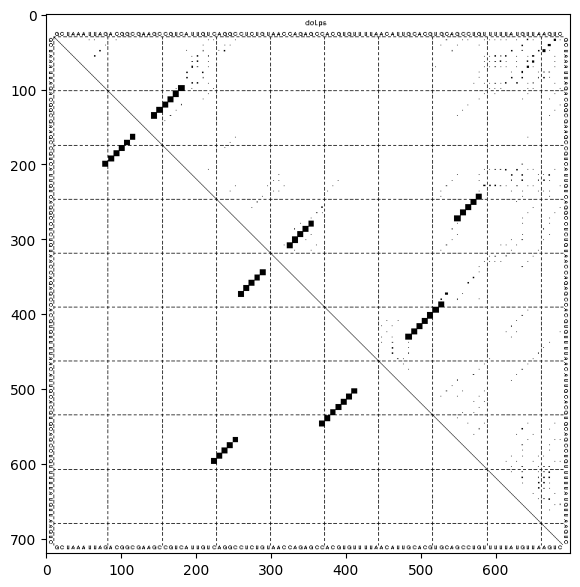

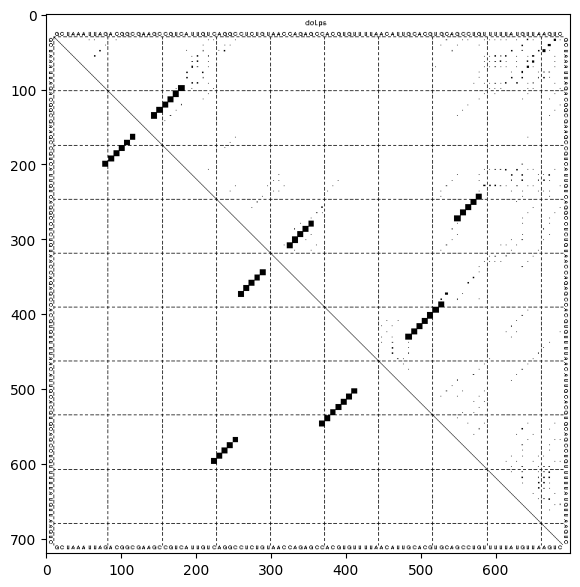

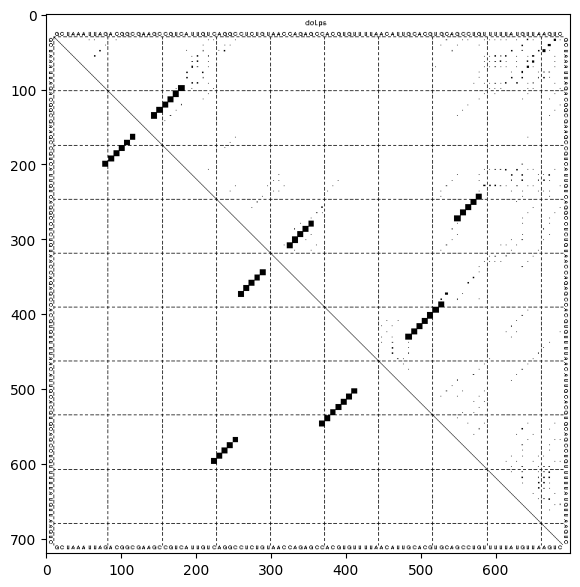

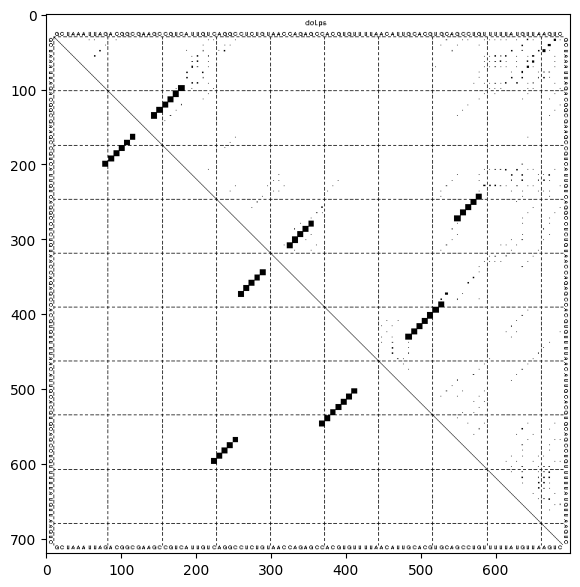

In [53]:
for i in range(len(designs)):
    target_ss = remove_positioned_gaps(best_seq, target)
    target_ss += xrRNA_strucs[j][0]

    seq = best_seq.replace('-', '') + xrRNA_seqs[j]
    !echo $seq > test.seq
    !RNAfold -p --MEA < test.seq
    #!convert dot.ps dot.png

    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    image = mpimg.imread("dot.ps")
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(image)
    print('-'*150)

['java', '-cp', '/home/mescalin/kgutenbrunner/Downloads/VARNAv3-93.jar', 'fr.orsay.lri.varna.applications.VARNAcmd', '-sequenceDBN', 'GCUAAAGAGCUUGCGUAAAGCAAGCAAAGUCAGGCCGGGUCCCCCGCCACGUGGAGCCCUUAUCCGCGUGCUGCCUGUAGGGAA', '-structureDBN', '........((((((.....))))))..{{.(((((((((...)))).((((((((.[[[[..))))))))}}))))).]]]]..', '-o', '/tmp/tmp274e0kpr.png', '-bp', '#006400', '-resolution', '2.0', '-bpStyle', 'simple', '-basesStyle1', 'fill=#ff0000', '-applyBasesStyle1on', '1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27', '-basesStyle2', 'fill=#008000', '-applyBasesStyle2on', '28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99']


Output file: /tmp/tmp274e0kpr.png



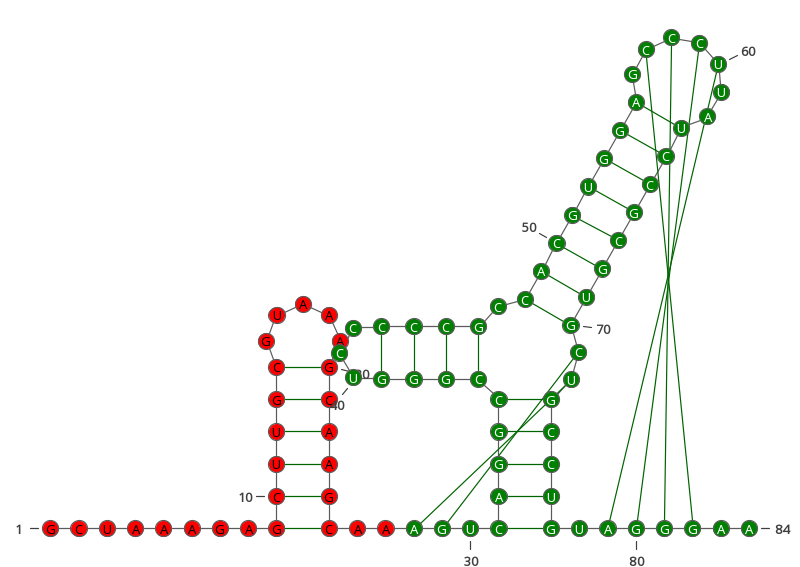

['java', '-cp', '/home/mescalin/kgutenbrunner/Downloads/VARNAv3-93.jar', 'fr.orsay.lri.varna.applications.VARNAcmd', '-sequenceDBN', 'GCUAAAGAGCUUGCGUAAAGCAAGCAAAGUCAGGCCGGGUCCCCCGCCACGUGGAGCCCUUAUCCGCGUGCUGCCUGUAGGGAA', '-structureDBN', '........((((((.....))))))..{{.(((((((((...)))).((((((((.[[[[..))))))))}}))))).]]]]..', '-o', '/scr/aldea/kgutenbrunner/working/xrRNA_design/MBFV_design/leader_design/structure.png', '-bp', '#006400', '-resolution', '2.0', '-bpStyle', 'simple', '-basesStyle1', 'fill=#ff0000', '-applyBasesStyle1on', '1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27', '-basesStyle2', 'fill=#008000', '-applyBasesStyle2on', '28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99']


Output file: /scr/aldea/kgutenbrunner/working/xrRNA_design/MBFV_design/leader_design/structure.png



In [38]:
from varnaapi import Structure
import varnaapi
seq =  'GCUAAAGAGCUUGCGUAAAGCAAGCAAAGUCAGGCCGGGUCCCCCGCCACGUGGAGCCCUUAUCCGCGUGCUGCCUGUAGGGAA'
ss =  r'........((((((.....))))))..{{.(((((((((...)))).((((((((.[[[[..))))))))}}))))).]]]]..'
v = varnaapi.Structure(sequence=seq, structure=ss)
# .update(bpStyle='simple', drawBackbone=True, bp='#006400', fillBases=True, spaceBetweenBases=1, resolution=2)


v.update(bpStyle='simple', drawBackbone=True, bp='#006400', fillBases=True, spaceBetweenBases=1, resolution=2)
style_leader = varnaapi.param.BasesStyle(fill="red")
style_xrRNA = varnaapi.param.BasesStyle(fill="green")

v.add_bases_style(style_leader, list(range(1,28)))
v.add_bases_style(style_xrRNA, list(range(28,100)))

v.update(bpStyle='simple', drawBackbone=True, bp='#006400', fillBases=True, spaceBetweenBases=1, resolution=2)

v.show()
# v.savefig('/scr/aldea/kgutenbrunner/working/xrRNA_design/MBFV_design/leader_design/structure.png')


## using MC

In [9]:
import random
import math

In [104]:
def mc_optimize(model, objective, steps, temp):
    sampler = ir.Sampler(model)
    cur = sampler.sample()
    cur_seq = rna.values_to_seq(cur.values())
    curval = objective(cur_seq)
    best, bestval = cur, curval
    ccs = model.connected_components()
    weights = [1 / len(cc) for cc in ccs]

    for i in (range(steps)):  # tqdm
        cc = random.choices(ccs, weights)[0]
        new = sampler.resample(cc, cur)

        new_seq = rna.values_to_seq(new.values())
        newval = objective(new_seq)
        if (newval >= curval or random.random() <= math.exp((newval - curval) / temp)):
            cur, curval = new, newval
            if curval > bestval:
                best, bestval = cur, curval

        print(f'Done: {i/steps:.4f}%\tbest TF: {bestval:.2f}', end='\r')
    return (best, bestval), sampler

In [10]:
def objective_function(sequence, target, freq_threshold=0.1):
    global xrRNA_strucs
    global xrRNA_seqs
    cur_sum_freq = 0
    for j in range(len(designs)):
        target_ss = remove_positioned_gaps(sequence, target)
        target_ss += xrRNA_strucs[j][0]
    
        whole_seq = sequence + xrRNA_seqs[j]
        cur_freq = target_frequency(whole_seq, target_ss)
        if cur_freq <= freq_threshold:
            return 0
        cur_sum_freq += cur_freq
    return cur_sum_freq


In [106]:
steps = 100000
(best, bestval), sampler = mc_optimize(model,
                                lambda sequence: objective_function(sequence, target),
                                steps,
                                0.01,
                                )

print(bestval)

1.8074616838623168 TF: 1.81


In [ ]:
best_seq = rna.values_to_seq(best.values())
for j in range(len(designs)):
    target_ss = remove_positioned_gaps(best_seq, target)
    target_ss += xrRNA_strucs[j][0]
    whole_seq = best_seq + xrRNA_seqs[j]
    print(f'{target_frequency(whole_seq, target_ss):.2f}')

In [11]:
stored = ['GCUAAGUAAGGUCCCCUCGGGGACCAA--', 'GCUAAAGUUGGGGGCUCCGGCCCCCUG--', 'GCUAAAAA-GUCGCCCAUCGGCGACAA-U', 'GCUAAAUUAGACGGCGAA-GCCGUCAU--', 'GCUAAUUUCGCCCCCGUUAGGGGGCUU--']

In [12]:
for seq in stored:
    print(seq)
    tfs = []
    for j in range(len(designs)):
        target_ss = remove_positioned_gaps(seq, target)
        target_ss += xrRNA_strucs[j][0]
        whole_seq = seq + xrRNA_seqs[j]
        cur_tf = target_frequency(whole_seq, target_ss)
        tfs.append(cur_tf)
        print(f'{cur_tf:.2f}')
    print(f'sum tf: {np.sum(tfs):.3f}\tmean tf: {np.mean(tfs):.3f}')
    print('-'*50)

GCUAAGUAAGGUCCCCUCGGGGACCAA--
0.44
0.52
0.55
0.36
sum tf: 1.872	mean tf: 0.468
--------------------------------------------------
GCUAAAGUUGGGGGCUCCGGCCCCCUG--
0.31
0.46
0.61
0.42
sum tf: 1.807	mean tf: 0.452
--------------------------------------------------
GCUAAAAA-GUCGCCCAUCGGCGACAA-U
0.28
0.50
0.52
0.31
sum tf: 1.611	mean tf: 0.403
--------------------------------------------------
GCUAAAUUAGACGGCGAA-GCCGUCAU--
0.33
0.55
0.64
0.46
sum tf: 1.977	mean tf: 0.494
--------------------------------------------------
GCUAAUUUCGCCCCCGUUAGGGGGCUU--
0.26
0.56
0.71
0.53
sum tf: 2.057	mean tf: 0.514
--------------------------------------------------


In [20]:
best_seq = 'GCUAAAUUAGACGGCGAA-GCCGUCAU--'

In [21]:
# get structure from sample
culled_structures = remove_positioned_gaps(best_seq, target)
culled_seq = best_seq.replace('-','')
best_seq

'GCUAAAUUAGACGGCGAA-GCCGUCAU--'

In [36]:
target

'.........((((((....))))))....'

GCUAAAUUAGACGGCGAAGCCGUCAUUGUCAGGCCUAGGAAAAGACUAGCCACGGAUGCGUUCAAUUCGUGCAGCCUGUUUGAGUGUUU
.........((((((...)))))).....(((((((((.......)))).(((((((.......)))))))..)))))........... (-25.30)
.........((((((...)))))).....(((((((((.......)))).(((((((.......)))))))..)))))....,,..... [-25.99]
.........((((((...)))))).....(((((((((.......)))).(((((((.......)))))))..)))))........... {-25.30 d=3.32}
.........((((((...)))))).....(((((((((.......)))).(((((((.......)))))))..)))))........... {-25.30 MEA=83.23}
 frequency of mfe structure in ensemble 0.325263; ensemble diversity 6.11  
------------------------------------------------------------------------------------------------------------------------------------------------------
GCUAAAUUAGACGGCGAAGCCGUCAUUGUCAGGCCUCGUCCAGUCGAGCCACGUGCCGGUCCGAGGUACGUGCAGCCUGUUUUUCCGGAUUUU
.........((((((...)))))).....(((((((((......)))).((((((((.......))))))))..))))).............. (-32.30)
.........((((((...)))))).....(((((((((......)))).((((((((.......)))))))).

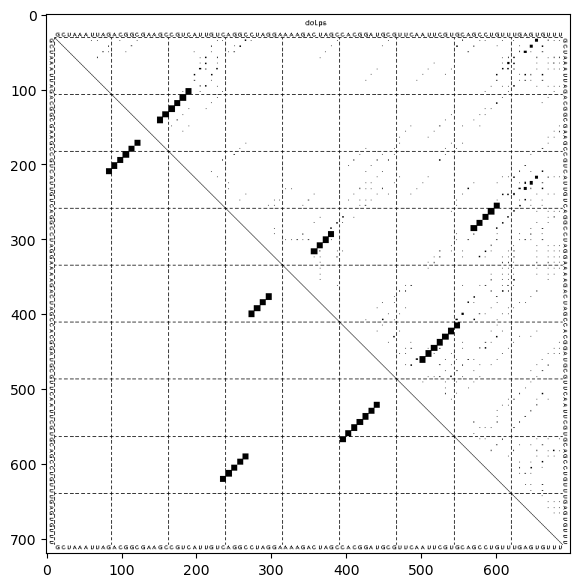

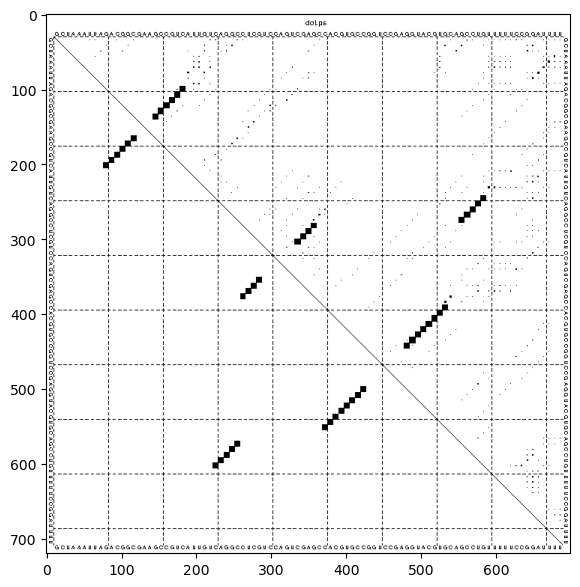

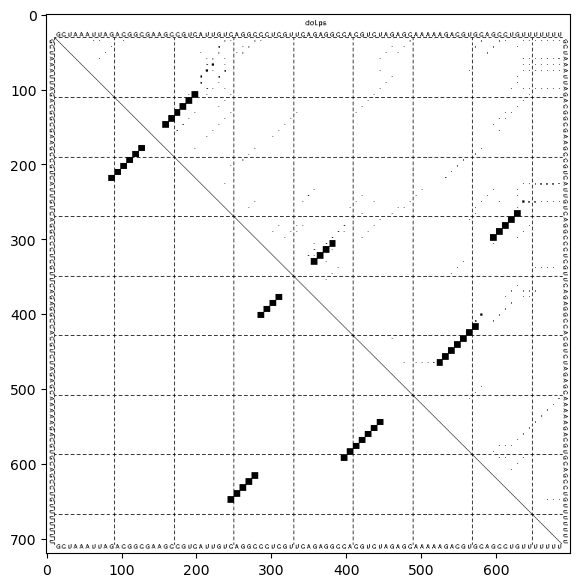

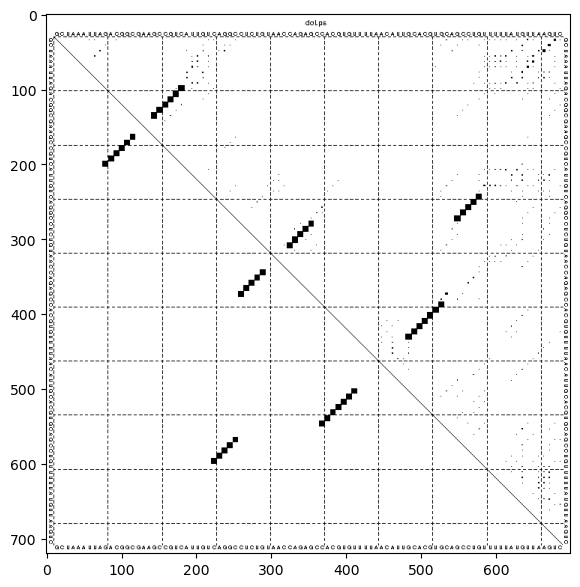

In [23]:
for i in range(len(designs)):
    target_ss = remove_positioned_gaps(culled_seq, target)
    target_ss += xrRNA_strucs[i][0]

    seq = culled_seq.replace('-', '') + xrRNA_seqs[i]
    !echo $seq > test.seq
    !RNAfold -p --MEA < test.seq
    #!convert dot.ps dot.png

    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    image = mpimg.imread("dot.ps")
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(image)
    print('-'*150)

In [33]:
for i in range(len(designs)):
    target_ss = remove_positioned_gaps(best_seq, target)
    seq = culled_seq.replace('-', '') + xrRNA_seqs[i]
    print(seq)
    print(target_ss + xrRNA_strucs[i][0])
    for j in range(1,3): print(len(target_ss) * '.' + xrRNA_strucs[i][j])

GCUAAAUUAGACGGCGAAGCCGUCAUUGUCAGGCCUAGGAAAAGACUAGCCACGGAUGCGUUCAAUUCGUGCAGCCUGUUUGAGUGUUU
.........((((((...)))))).....(((((((((.......)))).(((((((.......)))))))..)))))...........
..........................((...........................................))................
.........................................................((((((..................))))))..
GCUAAAUUAGACGGCGAAGCCGUCAUUGUCAGGCCUCGUCCAGUCGAGCCACGUGCCGGUCCGAGGUACGUGCAGCCUGUUUUUCCGGAUUUU
.........((((((...)))))).....(((((((((......)))).((((((((.......))))))))..)))))..............
..........................((............................................))...................
.........................................................((((((......................))))))..
GCUAAAUUAGACGGCGAAGCCGUCAUUGUCAGGCCCUCGUUCAGAGGCCACGUCUAGAGCAAAAAGACGUGCAGCCUGUUUUUUU
.........((((((...)))))).....(((((((((.....)))).(((((((.........)))))))..))))).......
..........................((...........................................))............
......

In [35]:
design7

'UGUCAGGCCCUC-GUUCA---GAGGCCACGUCU-A------GAG-----CAAAA-AGACGUGCAGCCUGUU---------UUUUU'